In [1]:
import nmresearch as nmr
import pickle # this loads data from saved numpy arrays

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.linalg import expm

In [2]:
x = np.matrix([[0,1],[1,0]])
y = np.matrix([[0,-1j],[1j,0]])
z = np.matrix([[1,0],[0,-1]])

def Rz(theta):
    return expm(-1j*(theta/2)*z)

def Rphi(theta,phi):
    return expm(-1j*(theta/2)*(np.cos(phi)*x + np.sin(phi)*y))

def RphiExp(theta,phi):
    return Rphi(np.pi/18, phi+np.pi/2) @ Rphi(theta,phi)

In [3]:
# make sure things work

rho = np.array([[1,0],[0,0]])
np.trace(rho @ z)

1

In [4]:
# Experimental procedure: y, -x, <z>. Shift first pulse phase by a degree

def Uexp(eps):
    return RphiExp(np.pi/2, np.pi) @ RphiExp(np.pi/2, np.pi/2 + eps)

error = np.real([np.trace((Uexp(k*(np.pi/180)) @ rho @ Uexp(k*(np.pi/180)).conjugate().transpose()) @ z) for k in range(15)])

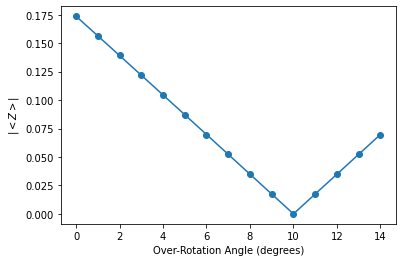

In [5]:
plt.plot(list(range(15)),abs(error))
plt.scatter(list(range(15)),abs(error))
plt.xlabel("Over-Rotation Angle (degrees)")
plt.ylabel(r"$|<Z>|$")
plt.show()

In [6]:
# nmr.Experiment(601).calibrate_framechange(phase_inc=1)
vals_cal = nmr.Experiment(601,folder="expt6").load_tpc3d(normalize=False)

C:\Users\awsta\Documents\workspace\qeg-env\lib\site-packages\nmrglue\fileio\bruker.py:394: UserWarning: Error reading the pulse program
  warn('Error reading the pulse program')


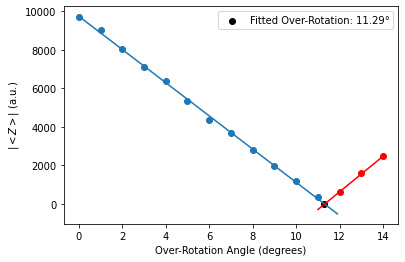

In [7]:
signal = sum(abs(vals_cal.transpose()))
normalized = signal/max(signal)

left = signal[0:12]
right = signal[12:]

p_left = np.polyfit(list(range(0,12)),left,1)
p_right = np.polyfit(list(range(12,15)),right, 1)

x_left = np.arange(0,12,.1)
x_right = np.arange(11,14,.1)

plt.plot(x_left, p_left[0]*x_left+p_left[1])
plt.plot(x_right, p_right[0]*x_right+p_right[1], color='red')
plt.scatter(list(range(12)),signal[0:12])
plt.scatter(list(range(12,15)),signal[12:],color='red')
plt.scatter(-p_left[1]/p_left[0],0,color='black',label="Fitted Over-Rotation: {:.2f}\xb0".format(-p_left[1]/p_left[0]))
plt.xlabel("Over-Rotation Angle (degrees)")
plt.ylabel(r"$|<Z>|$ (a.u.)")
plt.legend()
plt.show()

In [8]:
# Experimental Pulse sequnce which should do nothing
U1 = RphiExp(np.pi/2, np.pi) @ RphiExp(np.pi/2, 0)
print("deviation from expected:")
1-np.real(np.trace(U1 @ rho @ U1.conjugate().transpose() @ z))

deviation from expected:


0.015192246987792313

In [9]:
# Experimental Pulse sequnce which corrects for over-rotation
U2 = Rz(np.pi/18) @ RphiExp(np.pi/2, np.pi) @ Rz(np.pi/18) @ RphiExp(np.pi/2, 0)
print("deviation from expected:")
1-np.real(np.trace(U2 @ rho @ U2.conjugate().transpose() @ z))

deviation from expected:


1.3322676295501878e-15

In [10]:
def exp_fit(decay, show=False, c1=None, gauss=False):
    t = np.array(list(range(len(decay))))
    square = np.array([val**2 for val in t])
    tf = np.arange(0,t[-1],.1)
    tfsq = np.array([val**2 for val in tf])
    if gauss:
        p = np.polyfit(square, np.log(decay), 1)
    else:
        p = np.polyfit(t, np.log(decay), 1)
    
    if gauss:
        if c1 is not None:
            plt.plot(tf, np.exp(p[0]*tfsq+p[1]), label=r"$u = {}$, Fitted $\tau=${:.2f}".format(c1, np.sqrt(-1/p[0])))
            plt.scatter(t,decay,label=r"$u=${} data".format(c1))
        else:
            plt.plot(tf, np.exp(p[0]*tfsq+p[1]), label=r"Fitted $\tau=${:.2f}".format(np.sqrt(-1/p[0])))
            plt.scatter(t,decay,label="data")
    else:
        if c1 is not None:
            plt.plot(tf, np.exp(p[0]*tf+p[1]), label=r"$u = {}$, Fitted $\tau=${:.2f}".format(c1, -1/p[0]))
            plt.scatter(t,decay,label=r"$u=${} data".format(c1))
        else:
            plt.plot(tf, np.exp(p[0]*tf+p[1]), label=r"Fitted $\tau=${:.2f}".format(-1/p[0]))
            plt.scatter(t,decay,label="data")

    
    if show:
        plt.show() 
        plt.legend() 
        
    return np.sqrt(-1/p[0]) if gauss else -1/p[0]
    

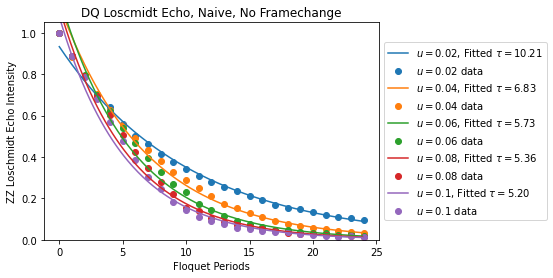

In [11]:
dq_echo_naive = nmr.Experiment(604,folder='expt6').load_tpc3d()
cnst1 = [0,.02,.04,.06,.08,.10]

naive_tau = []

for decay, c1 in zip(dq_echo_naive[1:], cnst1[1:]):
    naive_tau.append(exp_fit(decay, c1=c1,gauss=False))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Floquet Periods")
plt.ylabel("ZZ Loschmidt Echo Intensity")
plt.title("DQ Loscmidt Echo, Naive, No Framechange")
plt.ylim([0,1.05])
plt.show()

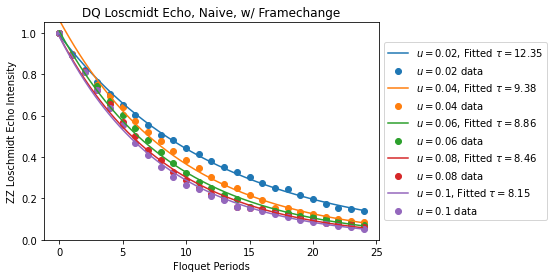

In [12]:
dq_echo_naive_fc = nmr.Experiment(611,folder='expt6').load_tpc3d()
cnst1 = [0,.02,.04,.06,.08,.10]

naive_fc_tau =[]

for decay, c1 in zip(dq_echo_naive_fc[1:], cnst1[1:]):
    naive_fc_tau.append(exp_fit(decay, c1=c1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Floquet Periods")
plt.ylabel("ZZ Loschmidt Echo Intensity")
plt.title("DQ Loscmidt Echo, Naive, w/ Framechange")
plt.ylim([0,1.05])
plt.show()

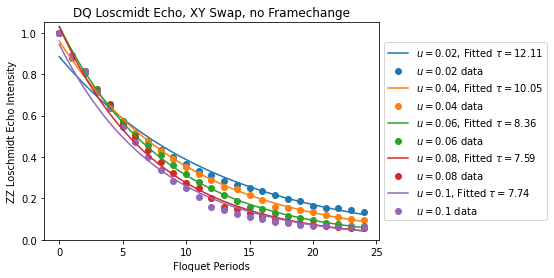

In [13]:
dq_echo_swap = nmr.Experiment(612,folder='expt6').load_tpc3d()
cnst1 = [0,.02,.04,.06,.08,.10]

swap_tau = []

for decay, c1 in zip(dq_echo_swap[1:], cnst1[1:]):
    swap_tau.append(exp_fit(decay, c1=c1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Floquet Periods")
plt.ylabel("ZZ Loschmidt Echo Intensity")
plt.ylim([0,1.05])
plt.title("DQ Loscmidt Echo, XY Swap, no Framechange")
plt.show()

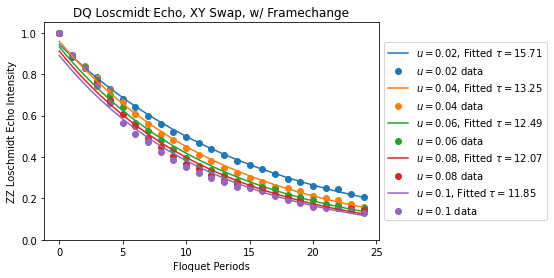

In [14]:
dq_echo_swap_fc = nmr.Experiment(614,folder='expt6').load_tpc3d()
cnst1 = [0,.02,.04,.06,.08,.10]

swap_fc_tau = []

for decay, c1 in zip(dq_echo_swap_fc[1:], cnst1[1:]):
    swap_fc_tau.append(exp_fit(decay, c1=c1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Floquet Periods")
plt.ylabel("ZZ Loschmidt Echo Intensity")
plt.title("DQ Loscmidt Echo, XY Swap, w/ Framechange")
plt.ylim([0,1.05])
plt.show()

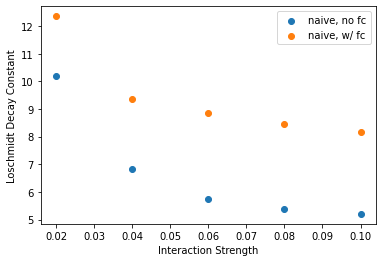

In [15]:
plt.scatter(cnst1[1:],naive_tau,label="naive, no fc")
plt.scatter(cnst1[1:],naive_fc_tau,label="naive, w/ fc")
plt.xlabel("Interaction Strength")
plt.ylabel("Loschmidt Decay Constant")
plt.legend()
plt.show()

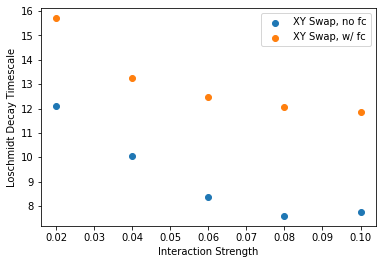

In [16]:
plt.scatter(cnst1[1:],swap_tau,label="XY Swap, no fc")
plt.scatter(cnst1[1:],swap_fc_tau,label="XY Swap, w/ fc")
plt.xlabel("Interaction Strength")
plt.ylabel("Loschmidt Decay Timescale")
plt.legend()
plt.show()

In [17]:
def func(x, a, b, c, d):
    return d * np.exp(- (x / a) ** b ) + c
def fancy_fit(vals, T, title=None, real_time=True, save=None, ylabel=None):
    decay=abs(vals)
    x = np.arange(0,len(decay))
    guess=25
    if real_time:
        x = x*T
        guess=2000
    
    popt, pcov = curve_fit(func, x, decay, p0=[guess, 4/5, 0, 1])
    perr = np.sqrt(np.diag(pcov))

    plt.plot(x, func(x, *popt), 'r-',label=r'Fit: $\tau_F$=%5.3f, b=%5.3f' % tuple(popt[0:2]))
    plt.scatter(x, vals,label="Data")
    if real_time:
        plt.xlabel("Experimental Time (us)")
    else:
        plt.xlabel("Floquet Kicking Periods")
        
    if title is not None:
        plt.title(title)
    
    plt.ylabel("Signal (a.u.)") if ylabel is None else plt.ylabel(ylabel)
    
    plt.yticks(np.arange(0, 1.5, .5))

    plt.legend()
    if save is not None:
        plt.savefig(save+".pdf", format='pdf', dpi=900,bbox_inches='tight')
    plt.show()
    return perr

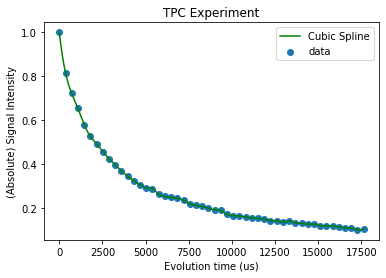

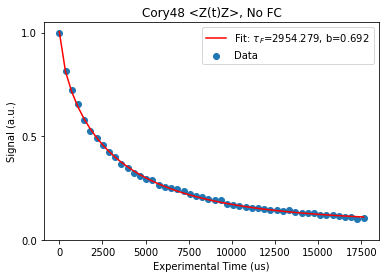

array([4.00394446e+01, 9.16789315e-03, 3.50094233e-03, 6.92259219e-03])

In [18]:
cory_zz = nmr.Experiment(23).tpc(cycle=24*3*5,)
t = np.arange(0,24*3*5*50, 24*3*5)
#tau = exp_fit(cory_zz,gauss=False)
fancy_fit(cory_zz,24*3*5,title="Cory48 <Z(t)Z>, No FC")

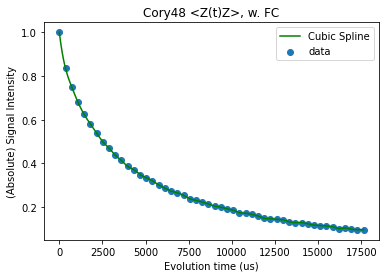

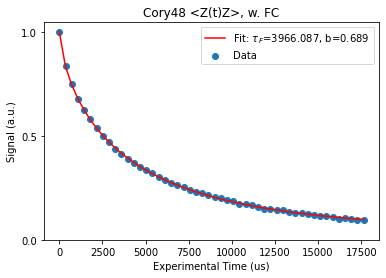

array([3.16596634e+01, 4.70219228e-03, 2.60446951e-03, 4.11212125e-03])

In [19]:
cory_zz_fc = nmr.Experiment(33).tpc(cycle=24*3*5,title="Cory48 <Z(t)Z>, w. FC")
fancy_fit(cory_zz_fc,24*3*5,title="Cory48 <Z(t)Z>, w. FC")

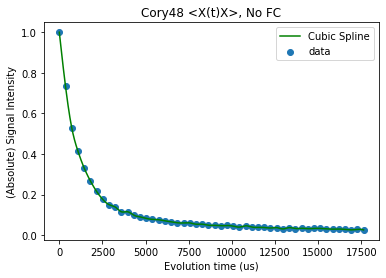

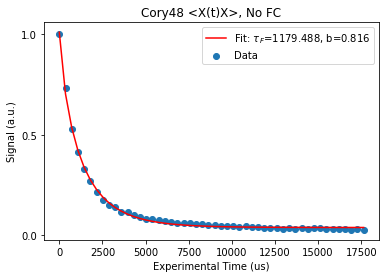

array([2.22785202e+01, 1.62844505e-02, 1.81865967e-03, 9.38627200e-03])

In [20]:
cory_xx = nmr.Experiment(76).tpc(cycle=24*3*5,title="Cory48 <X(t)X>, No FC")
t = np.arange(0,24*3*5*50, 24*3*5)
#tau = exp_fit(cory_xx,gauss=False)
fancy_fit(cory_xx,24*3*5,title="Cory48 <X(t)X>, No FC")

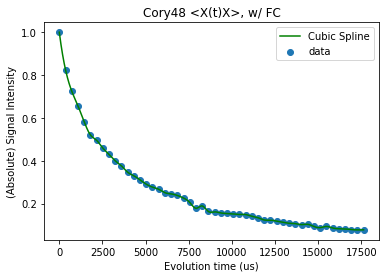

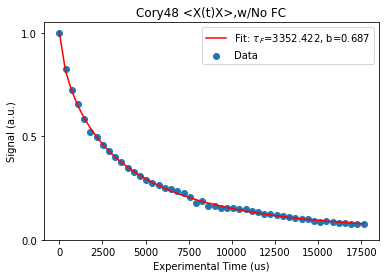

array([5.97247697e+01, 1.13659104e-02, 5.31884236e-03, 9.42164712e-03])

In [21]:
cory_xx_fc = nmr.Experiment(75).tpc(cycle=24*3*5,title="Cory48 <X(t)X>, w/ FC")
t = np.arange(0,24*3*5*50, 24*3*5)
#tau = exp_fit(cory_xx,gauss=False)
fancy_fit(cory_xx_fc,24*3*5,title="Cory48 <X(t)X>,w/No FC")

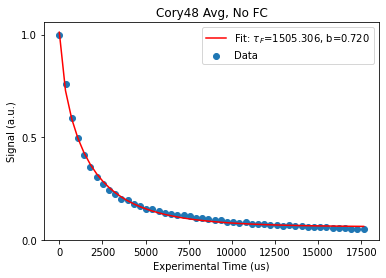

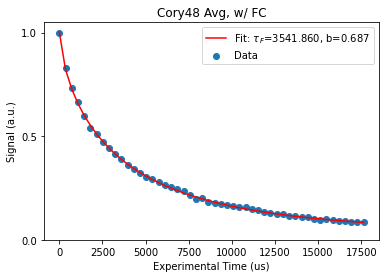

array([4.59112438e+01, 8.06337345e-03, 3.99609256e-03, 6.79612594e-03])

In [22]:
cory_avg = (1/3)*(cory_zz+2*cory_xx)
fancy_fit(cory_avg,24*3*5,title="Cory48 Avg, No FC")
cory_avg_fc = (1/3)*(cory_zz_fc+2*cory_xx_fc)
fancy_fit(cory_avg_fc,24*3*5,title="Cory48 Avg, w/ FC")

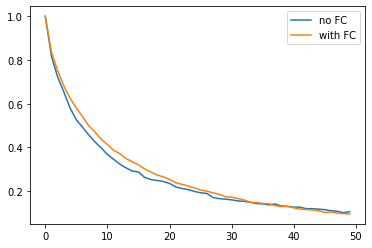

In [23]:
plt.plot(cory_zz,label="no FC")
plt.plot(cory_zz_fc,label="with FC")
plt.legend()
plt.show()

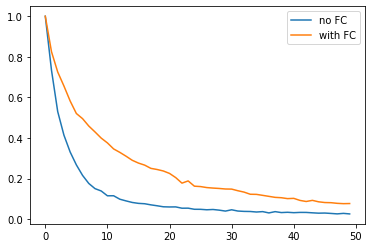

In [24]:
plt.plot(cory_xx,label="no FC")
plt.plot(cory_xx_fc,label="with FC")
plt.legend()
plt.show()

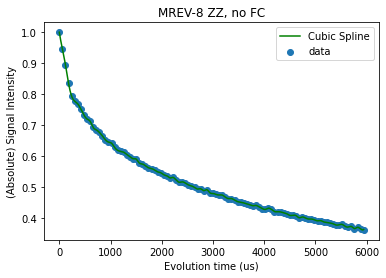

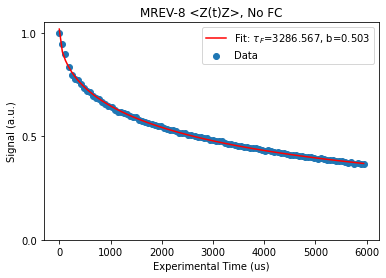

array([3.32595854e+02, 1.44108294e-02, 2.67092863e-02, 3.01079903e-02])

In [25]:
mrev_zz = nmr.Experiment(50).tpc(cycle=60,title="MREV-8 ZZ, no FC")
t = np.arange(0,60*100, 60)
fancy_fit(mrev_zz,60,title="MREV-8 <Z(t)Z>, No FC")

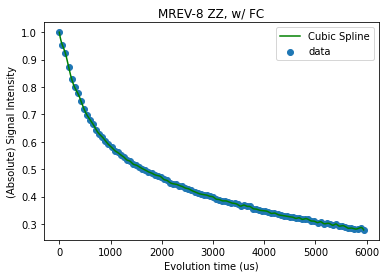

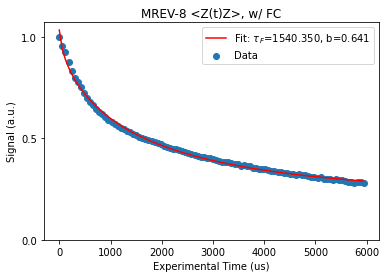

array([5.13108843e+01, 1.66291011e-02, 9.82195315e-03, 1.52871401e-02])

In [26]:
mrev_zz_fc = nmr.Experiment(51).tpc(cycle=60,title="MREV-8 ZZ, w/ FC")
t = np.arange(0,60*100, 60)
fancy_fit(mrev_zz_fc,60,title="MREV-8 <Z(t)Z>, w/ FC")

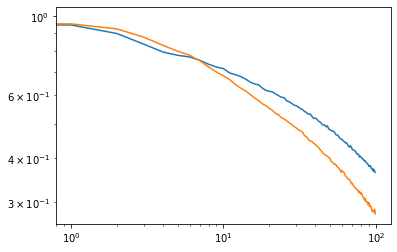

In [27]:
plt.loglog(mrev_zz)
plt.loglog(mrev_zz_fc)

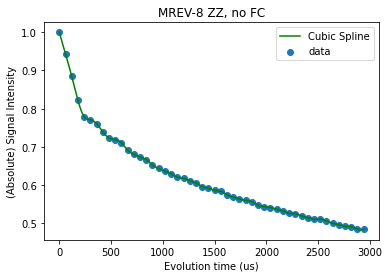

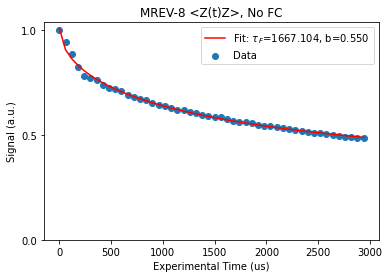

array([3.35114090e+02, 3.09495466e-02, 4.52733907e-02, 4.90297273e-02])

In [28]:
mrev_zz = nmr.Experiment(55).tpc(cycle=60,title="MREV-8 ZZ, no FC")
t = np.arange(0,60*100, 60)
fancy_fit(mrev_zz,60,title="MREV-8 <Z(t)Z>, No FC")

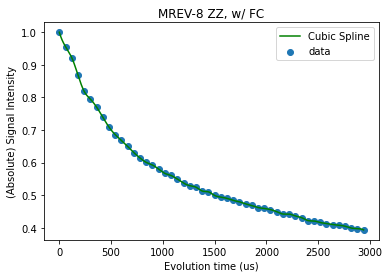

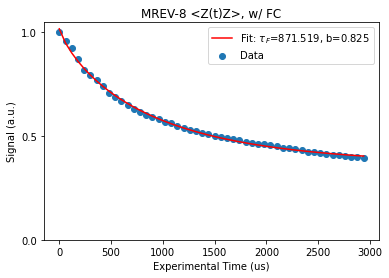

array([2.42143383e+01, 2.27809781e-02, 7.72916471e-03, 1.18242297e-02])

In [29]:
mrev_zz_fc = nmr.Experiment(56).tpc(cycle=60,title="MREV-8 ZZ, w/ FC")
t = np.arange(0,60*100, 60)
fancy_fit(mrev_zz_fc,60,title="MREV-8 <Z(t)Z>, w/ FC")

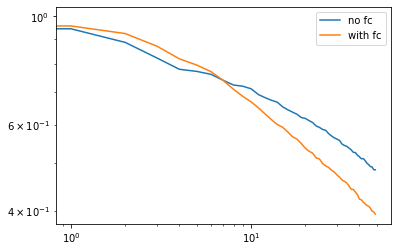

In [30]:
plt.loglog(mrev_zz,label="no fc")
plt.loglog(mrev_zz_fc,label="with fc")
plt.legend()
plt.show()

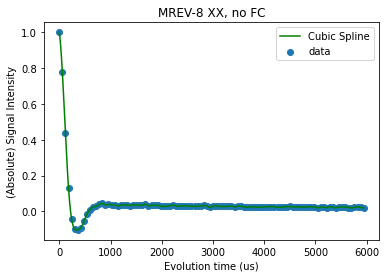

C:\Users\awsta\AppData\Local\Temp\ipykernel_29348\611578078.py:2: RuntimeWarning: divide by zero encountered in power
  return d * np.exp(- (x / a) ** b ) + c
C:\Users\awsta\AppData\Local\Temp\ipykernel_29348\611578078.py:2: RuntimeWarning: invalid value encountered in power
  return d * np.exp(- (x / a) ** b ) + c


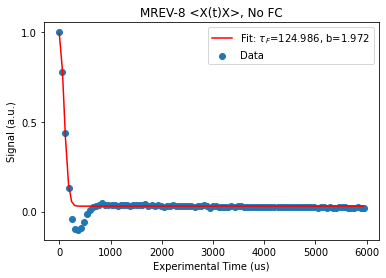

array([2.19413682e+00, 9.13939282e-02, 1.42130683e-03, 1.36306721e-02])

In [31]:
mrev_xx = nmr.Experiment(77).tpc(cycle=60,title="MREV-8 XX, no FC")
t = np.arange(0,60*100, 60)
fancy_fit(mrev_xx,60,title="MREV-8 <X(t)X>, No FC")

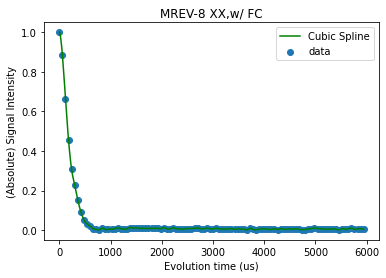

C:\Users\awsta\AppData\Local\Temp\ipykernel_29348\611578078.py:2: RuntimeWarning: divide by zero encountered in power
  return d * np.exp(- (x / a) ** b ) + c
C:\Users\awsta\AppData\Local\Temp\ipykernel_29348\611578078.py:2: RuntimeWarning: invalid value encountered in power
  return d * np.exp(- (x / a) ** b ) + c


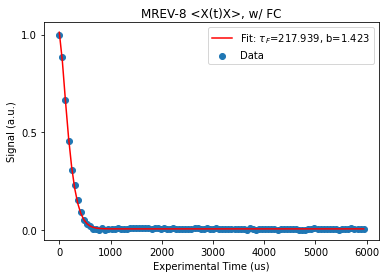

array([1.40985752e+00, 1.71858278e-02, 5.47035317e-04, 4.84030093e-03])

In [32]:
mrev_xx_fc = nmr.Experiment(78).tpc(cycle=60,title="MREV-8 XX,w/ FC")
t = np.arange(0,60*100, 60)
fancy_fit(mrev_xx_fc,60,title="MREV-8 <X(t)X>, w/ FC")

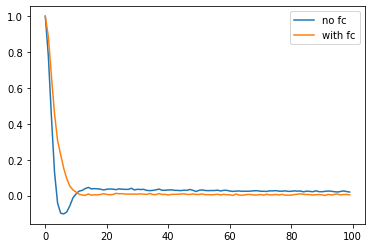

In [33]:
plt.plot(mrev_xx,label="no fc")
plt.plot(mrev_xx_fc,label="with fc")
plt.legend()
plt.show()

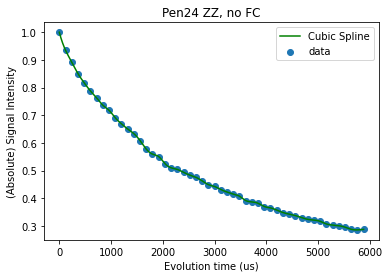

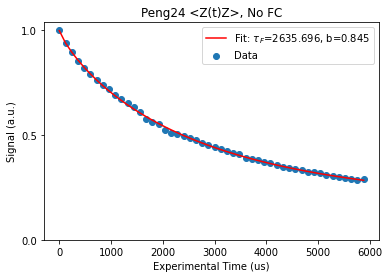

array([7.46049778e+01, 1.62525564e-02, 1.12334149e-02, 1.38492402e-02])

In [34]:
peng_zz = nmr.Experiment(64).tpc(cycle=120,title="Pen24 ZZ, no FC")
t = np.arange(0,120*50, 120)
fancy_fit(peng_zz,120,title="Peng24 <Z(t)Z>, No FC")

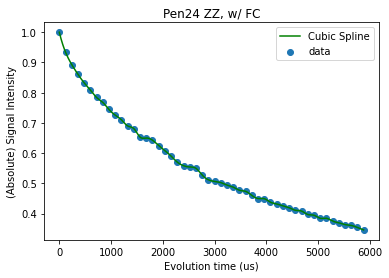

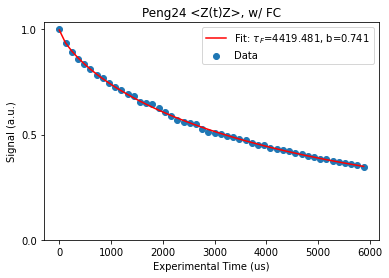

array([3.22997755e+02, 1.80126640e-02, 2.98458698e-02, 3.22168062e-02])

In [35]:
peng_zz_fc = nmr.Experiment(65).tpc(cycle=120,title="Pen24 ZZ, w/ FC")
t = np.arange(0,120*50, 120)
fancy_fit(peng_zz_fc,120,title="Peng24 <Z(t)Z>, w/ FC")

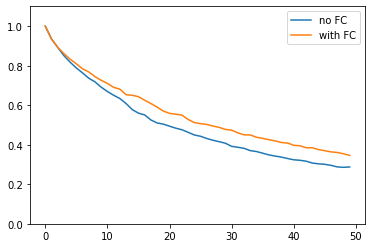

In [36]:
plt.plot(peng_zz,label="no FC")
plt.plot(peng_zz_fc,label="with FC")
plt.ylim([0,1.1])
plt.legend()
plt.show()

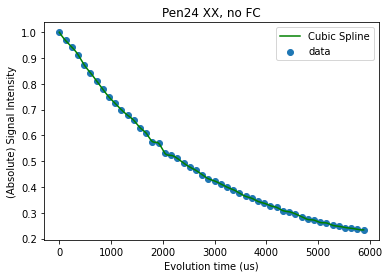

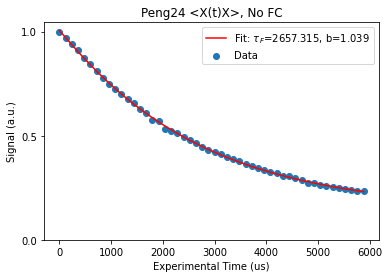

array([3.90536636e+01, 1.46071533e-02, 7.25342421e-03, 9.35028573e-03])

In [37]:
peng_xx = nmr.Experiment(66).tpc(cycle=120,title="Pen24 XX, no FC")
t = np.arange(0,120*50, 120)
fancy_fit(peng_xx,120,title="Peng24 <X(t)X>, No FC")

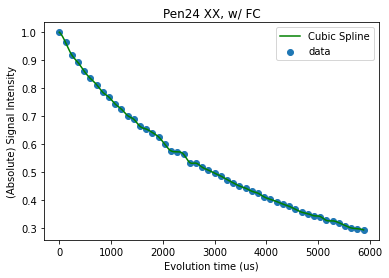

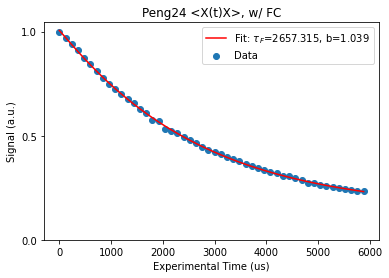

array([3.90536636e+01, 1.46071533e-02, 7.25342421e-03, 9.35028573e-03])

In [38]:
peng_xx_fc = nmr.Experiment(67).tpc(cycle=120,title="Pen24 XX, w/ FC")
t = np.arange(0,120*50, 120)
fancy_fit(peng_xx,120,title="Peng24 <X(t)X>, w/ FC")

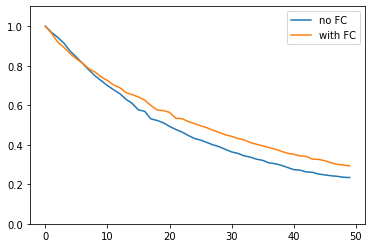

In [39]:
plt.plot(peng_xx,label="no FC")
plt.plot(peng_xx_fc,label="with FC")
plt.ylim([0,1.1])
plt.legend()
plt.show()

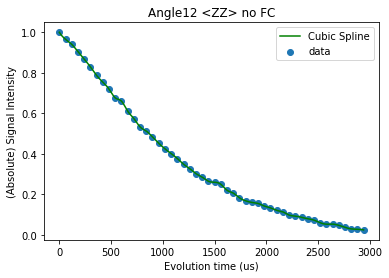

In [40]:
ang12_zz = nmr.Experiment(250).tpc(cycle=60,title="Angle12 <ZZ> no FC")

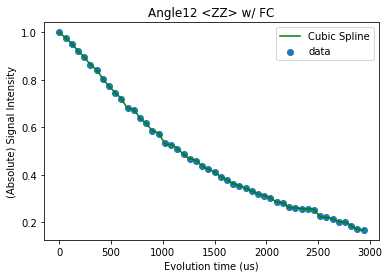

In [41]:
ang12_zz_fc = nmr.Experiment(251).tpc(cycle=60,title="Angle12 <ZZ> w/ FC")

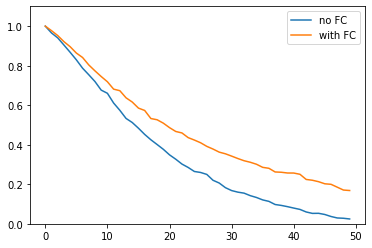

In [42]:
plt.plot(ang12_zz,label="no FC")
plt.plot(ang12_zz_fc,label="with FC")
plt.ylim([0,1.1])
plt.legend()
plt.show()

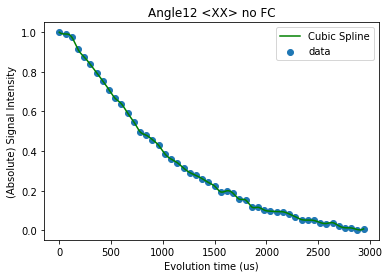

In [43]:
ang12_xx = nmr.Experiment(257).tpc(cycle=60,title="Angle12 <XX> no FC")

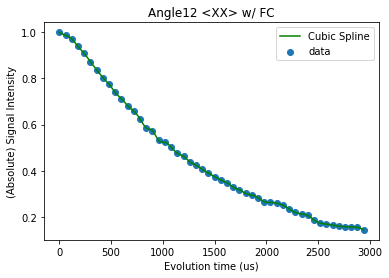

In [44]:
ang12_xx_fc = nmr.Experiment(258).tpc(cycle=60,title="Angle12 <XX> w/ FC")

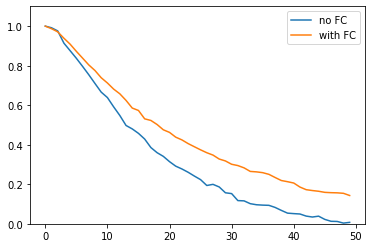

In [45]:
plt.plot(ang12_xx,label="no FC")
plt.plot(ang12_xx_fc,label="with FC")
plt.ylim([0,1.1])
plt.legend()
plt.show()